C:\Users\leewa\AppData\Local\Temp\ipykernel_25792\3287429138.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\leewa\AppData\Local\Temp\ipykernel_25792\3287429138.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
c:\Users\leewa\anaconda3\a cute anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


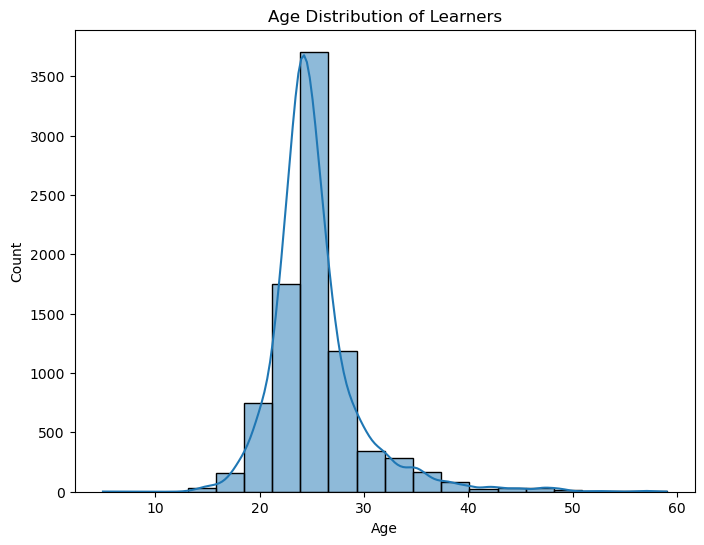

c:\Users\leewa\anaconda3\a cute anaconda\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


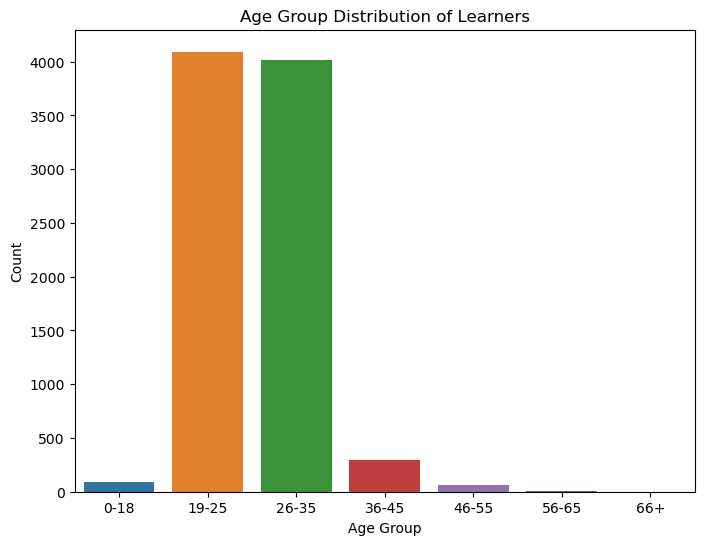

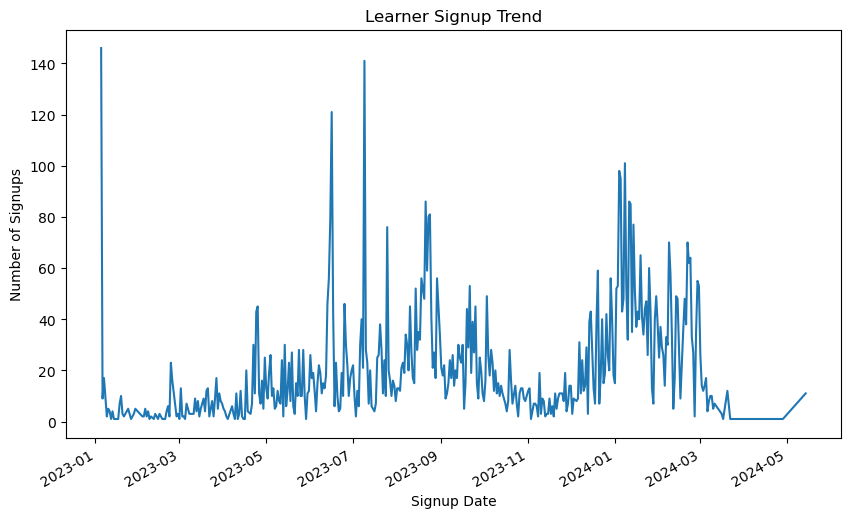

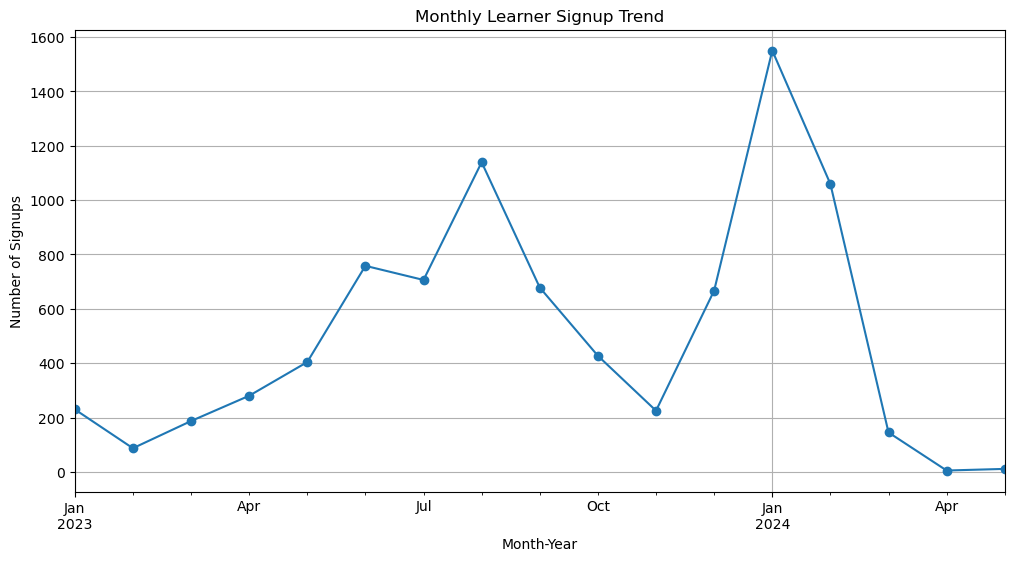

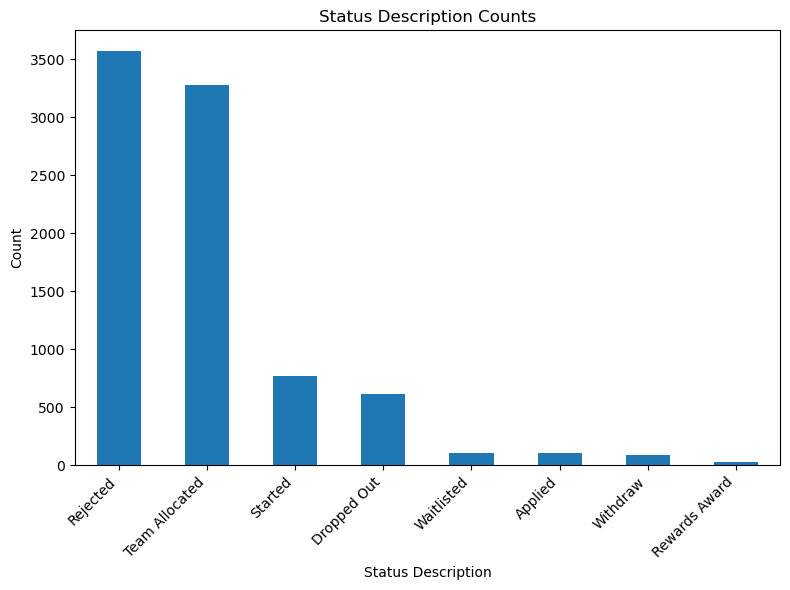

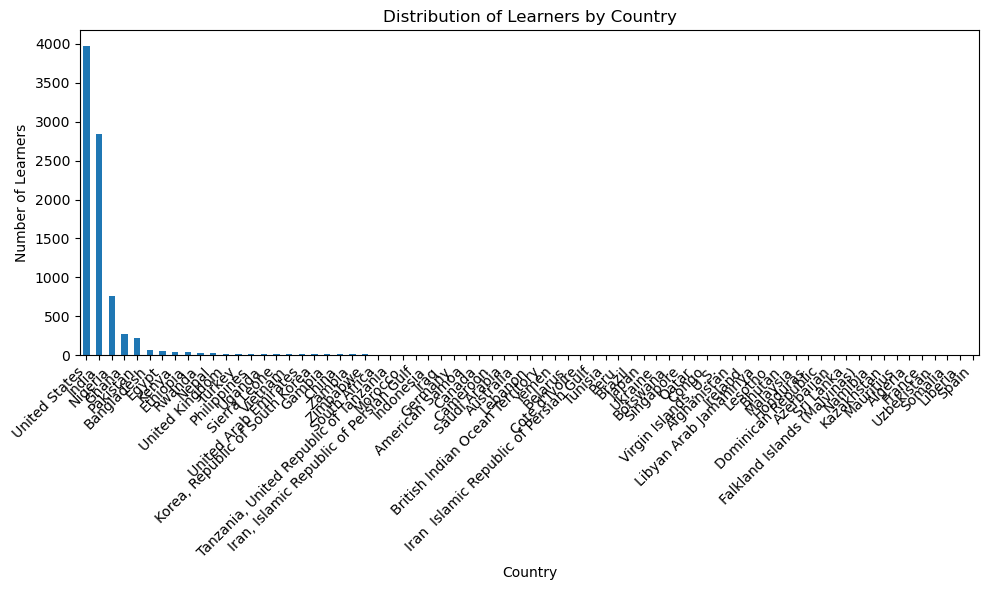

c:\Users\leewa\anaconda3\a cute anaconda\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


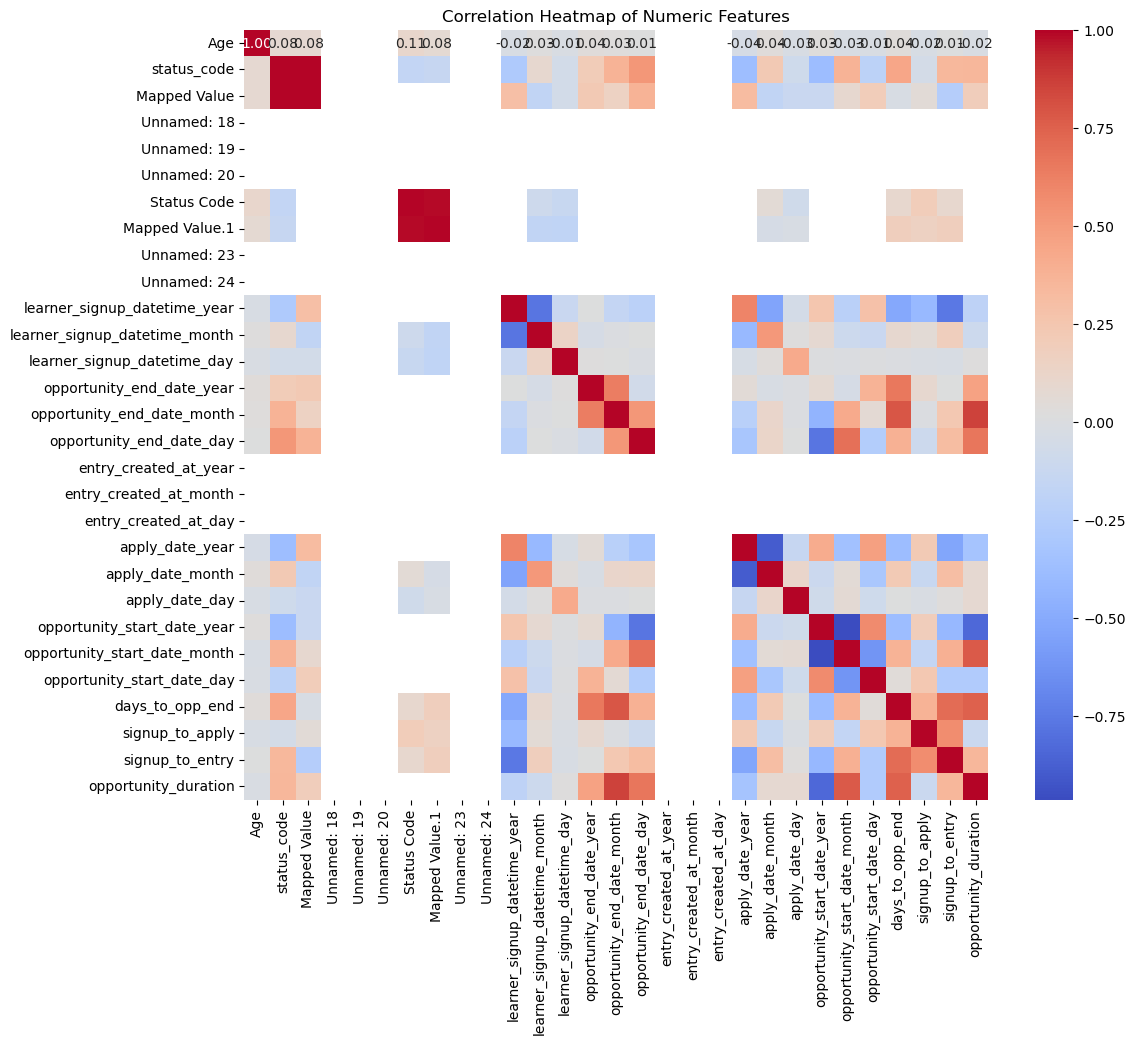

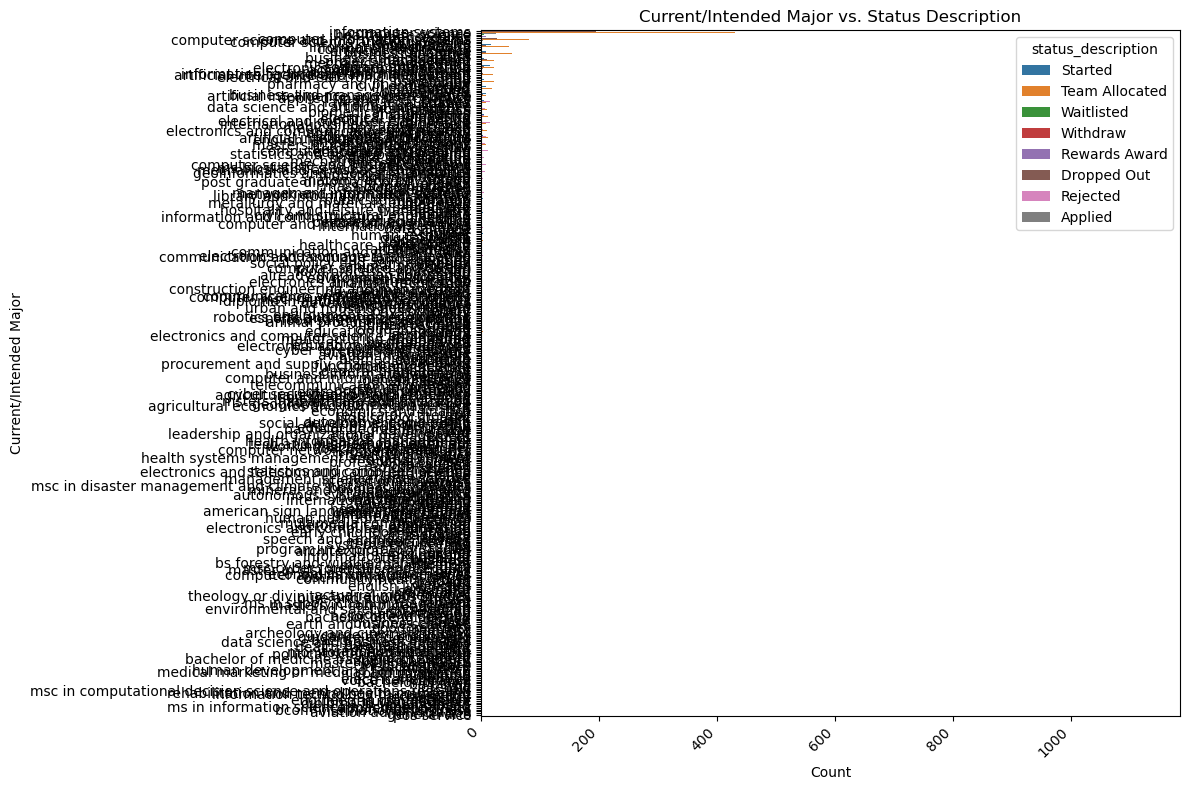

c:\Users\leewa\anaconda3\a cute anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


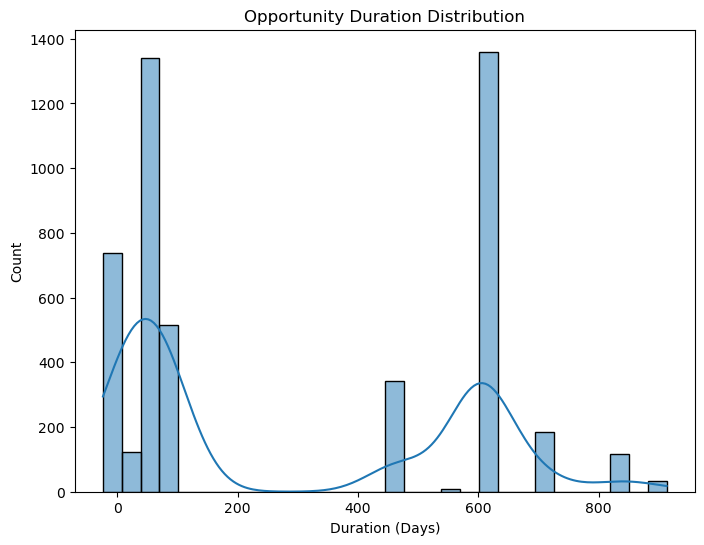

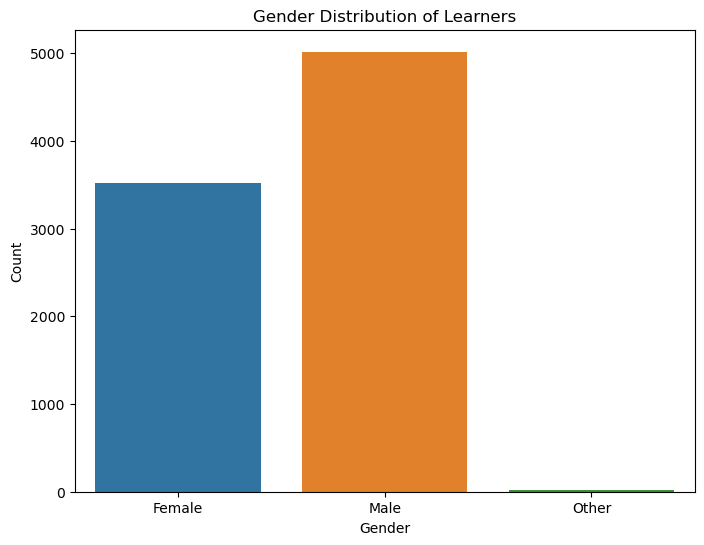

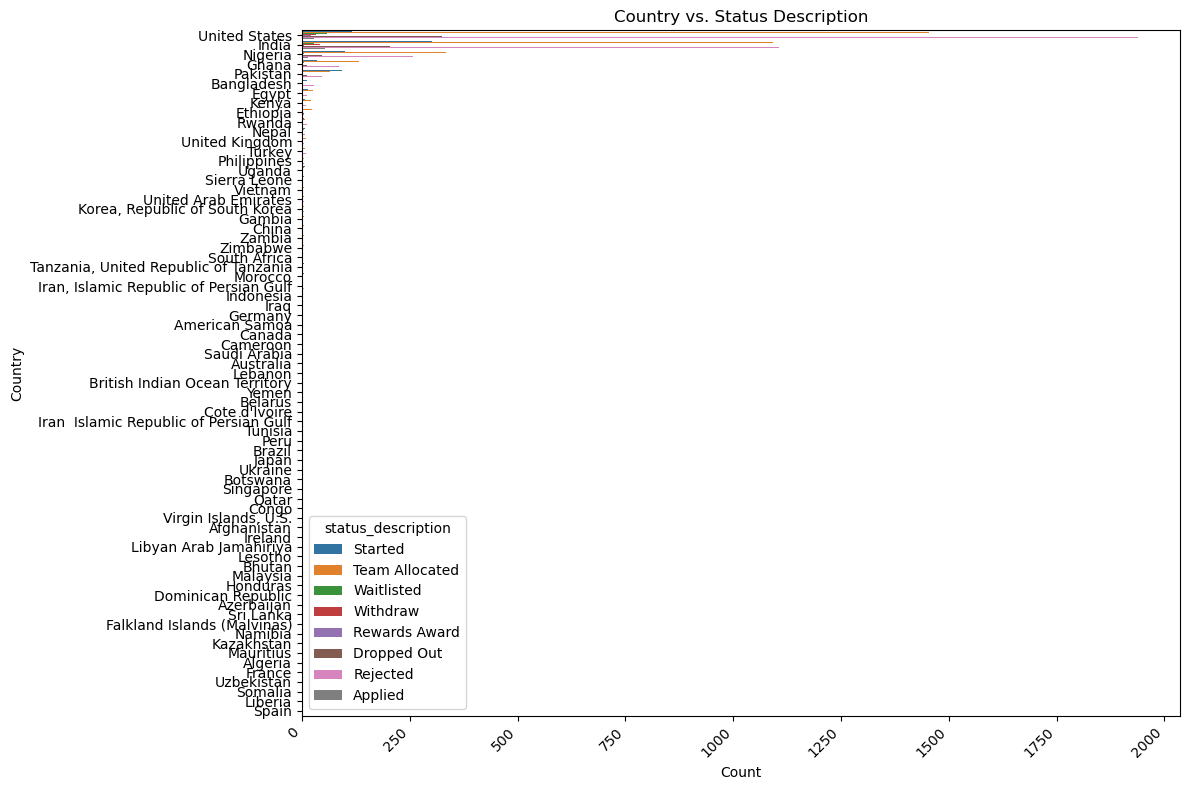

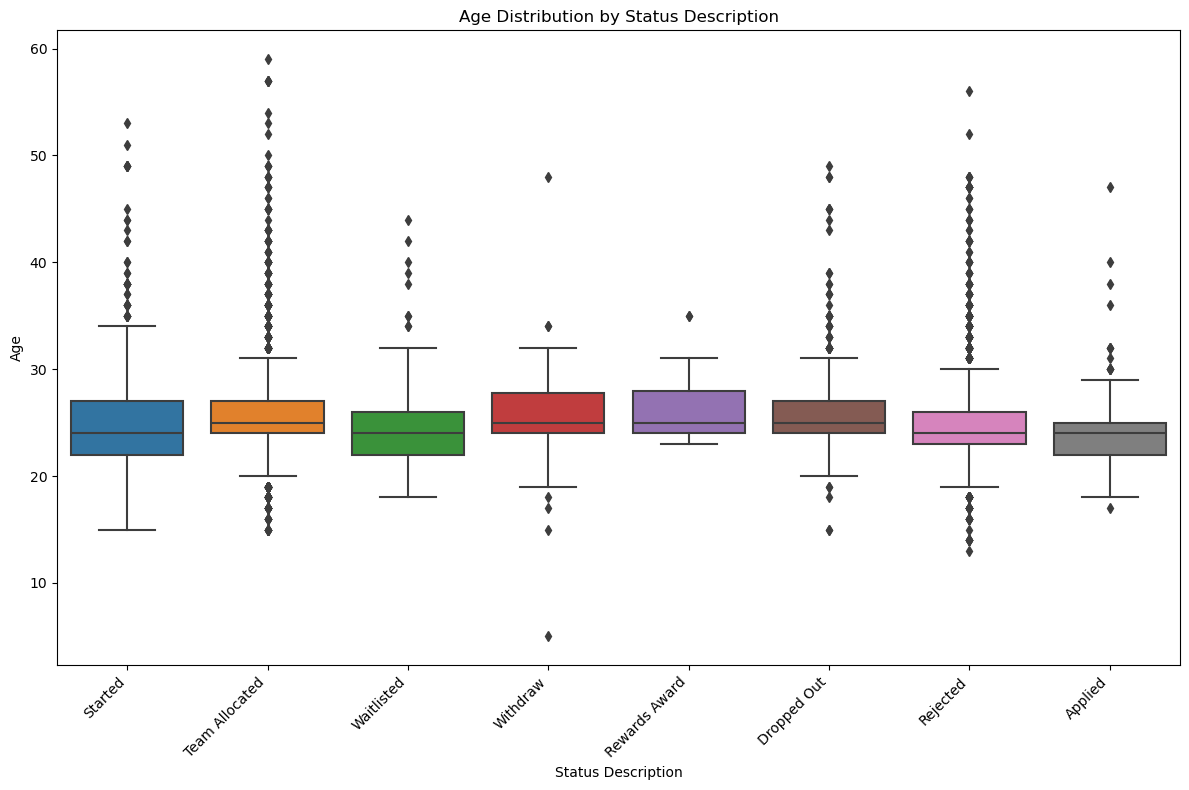

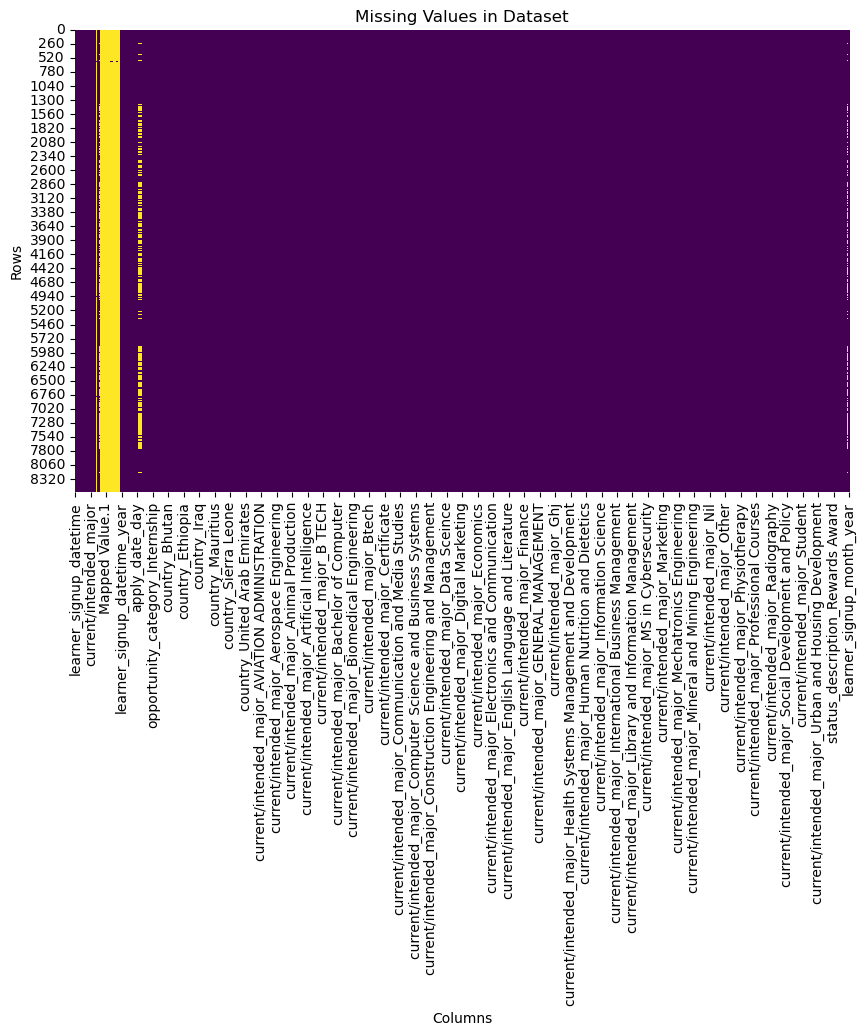

Feature engineering and visualization complete. Visualizations saved in the 'visualizations' folder.


In [2]:
#Sourabh Vamdevan
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv('cleaned dataset.csv')

def calculate_age(dob):
    if pd.isna(dob):
        return np.nan
    try:
        today = date.today()
        born = datetime.strptime(dob, "%m/%d/%Y").date()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    except ValueError:
        return np.nan

df['Age'] = df.apply(lambda x: calculate_age(x['date_of_birth']) if pd.isna(x['Age']) else x['Age'], axis=1)

bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

for col in ['learner_signup_datetime', 'opportunity_end_date', 'entry_created_at', 'apply_date', 'opportunity_start_date']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day

def safe_days_diff(date1, date2):
    try:
        return abs((date1 - date2).days)
    except TypeError:
        return -9999

df['days_to_opp_end'] = df.apply(lambda row: safe_days_diff(row['learner_signup_datetime'], row['opportunity_end_date']), axis=1)
df['signup_to_apply'] = df.apply(lambda row: safe_days_diff(row['learner_signup_datetime'], row['apply_date']), axis=1)
df['signup_to_entry'] = df.apply(lambda row: safe_days_diff(row['learner_signup_datetime'], row['entry_created_at']), axis=1)

df['gender'] = df['gender'].replace("Don't want to specify", "Other")
for col in ['opportunity_category', 'gender', 'country', 'current/intended_major', 'status_description', 'Status Description']:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)

for col in ['institution_name', 'Institution Name', 'current/intended_major', 'Current/Intended Major']:
    df[col] = df[col].str.lower().str.replace('[^a-zA-Z0-9\s]', '').str.strip()

df['opportunity_duration'] = (df['opportunity_end_date'] - df['opportunity_start_date']).dt.days

if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

plt.figure(figsize=(8, 6))
sns.histplot(df['Age'].dropna(), kde=True, bins=20)
plt.title('Age Distribution of Learners')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('visualizations/age_distribution.png')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='AgeGroup', data=df, order=labels)
plt.title('Age Group Distribution of Learners')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.savefig('visualizations/age_group_distribution.png')
plt.show()

plt.figure(figsize=(10, 6))
df['learner_signup_datetime'].value_counts().sort_index().plot()
plt.title('Learner Signup Trend')
plt.xlabel('Signup Date')
plt.ylabel('Number of Signups')
plt.savefig('visualizations/signup_trend.png')
plt.show()

df['learner_signup_month_year'] = df['learner_signup_datetime'].dt.to_period('M')
monthly_signups = df['learner_signup_month_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_signups.plot(kind='line', marker='o')
plt.title('Monthly Learner Signup Trend')
plt.xlabel('Month-Year')
plt.ylabel('Number of Signups')
plt.grid(True)
plt.savefig('visualizations/monthly_signup_trend.png')
plt.show()

plt.figure(figsize=(8, 6))
df['status_description'].value_counts().plot(kind='bar')
plt.title('Status Description Counts')
plt.xlabel('Status Description')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/status_description_counts.png')
plt.show()

plt.figure(figsize=(10, 6))
df['country'].value_counts().plot(kind='bar')
plt.title('Distribution of Learners by Country')
plt.xlabel('Country')
plt.ylabel('Number of Learners')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/country_distribution.png')
plt.show()

numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.savefig('visualizations/correlation_heatmap.png')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(y='current/intended_major', hue='status_description', data=df, order=df['current/intended_major'].value_counts().index)
plt.title('Current/Intended Major vs. Status Description')
plt.xlabel('Count')
plt.ylabel('Current/Intended Major')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/major_vs_status.png')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df['opportunity_duration'].dropna(), kde=True, bins=30)
plt.title('Opportunity Duration Distribution')
plt.xlabel('Duration (Days)')
plt.ylabel('Count')
plt.savefig('visualizations/opportunity_duration_distribution.png')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution of Learners')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig('visualizations/gender_distribution.png')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(y='country', hue='status_description', data=df, order=df['country'].value_counts().index)
plt.title('Country vs. Status Description')
plt.xlabel('Count')
plt.ylabel('Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/country_vs_status.png')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='status_description', y='Age', data=df)
plt.title('Age Distribution by Status Description')
plt.xlabel('Status Description')
plt.ylabel('Age')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/age_vs_status.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Dataset')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.savefig('visualizations/missing_values.png')
plt.show()

df.to_csv("engineered_dataset_with_additional_features.csv", index=False)

print("Feature engineering and visualization complete. Visualizations saved in the 'visualizations' folder.")